# A small sample demonstrating shadow mapping

In [2]:
import sys
import os

import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath('..')
sys.path.insert(0, ROOT_DIR)

import numpy as np

from OpenGL.GL import GL_DEPTH_ATTACHMENT
from pygl import get_offscreen_context, spherical_harmonics
from pygl.framebuffer import FrameBuffer
from pygl import shader as shader_lib
from pygl.texture import get_default_texture_2d
from pygl.camera import orthographic
from pygl import transform

import OpenGL.GL as gl

from samples import scenes, utils

No EGL found!


In [3]:
ctx = get_offscreen_context()

SHADOW_SHAP = (1024, 1024)

depth_map_fbo = FrameBuffer(SHADOW_SHAP)
depth_texture = depth_map_fbo.attach_texture(GL_DEPTH_ATTACHMENT)

scene = scenes.teapot_spiral()

default_fbo = FrameBuffer(scene.camera.screen_size)
color_tex = default_fbo.attach_texture(0)

shader = shader_lib.get_bling_phong_shader()
shadow_shader = shader_lib.get_shadow_map_shader()

illum = spherical_harmonics.default()

default_tex = get_default_texture_2d() 

gl.glEnable(gl.GL_DEPTH_TEST)

{GL_DEPTH_ATTACHMENT: <Texture2D: shape=(1024, 1024), format=<class 'numpy.float32'>, id=2>}


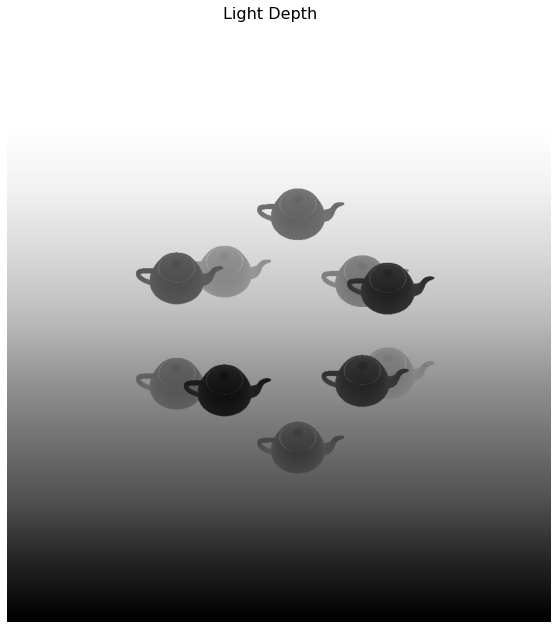

In [4]:
# Render the depth from the viewpoint of a directional light.
P = orthographic(-20, 20, -20, 20, 0.3, 50.0)
V = scene.camera.V @ transform.translate([0, 1, 0])
ls_VP = P@V

light_pos = np.linalg.inv(ls_VP)[:3, 3]

with depth_map_fbo:
    gl.glDrawBuffer(gl.GL_NONE);
    gl.glReadBuffer(gl.GL_NONE);

    default_fbo.clear_color_attachment(0, (0.0, 0.0, 0.0, 1.0))
    default_fbo.clear_depth_buffer()
    gl.glCullFace(gl.GL_FRONT)
    for instance in scene.instances:
        scene.objects[instance.object].render(
            shadow_shader,
            mvp=(ls_VP@instance.ModelMatrix))
    gl.glCullFace(gl.GL_BACK)

print(depth_map_fbo.attachments)
utils.display_images(depth_map_fbo, title="Light Depth", cmap='Greys_r')

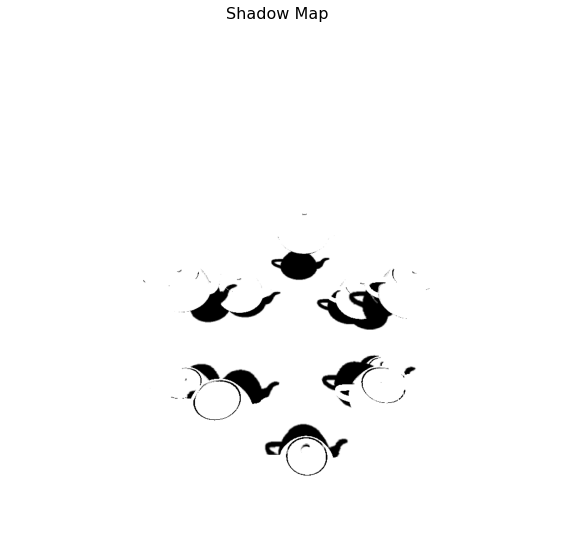

In [5]:
# A simple shader that renders the shadow values of the scene
shadow_vs = """#version 330 core
layout(location=0) in vec3 pos;
layout(location=2) in vec3 normal;

uniform mat4 mvp;
uniform mat4 normal_matrix;
uniform mat4 light_space_mvp;

out vec4 frag_pos;
out vec4 frag_normal;
out vec4 frag_light_space_pos;

void main() {
   frag_pos = mvp * vec4(pos, 1.0);
   frag_normal = normal_matrix * vec4(normal, 0.0);
   frag_light_space_pos = light_space_mvp * vec4(pos, 1.0);
   gl_Position = frag_pos;
}"""

shadow_fs  ="""#version 330 core
out vec4 FragColor;

in vec4 frag_pos;
in vec4 frag_normal;
in vec4 frag_light_space_pos;

uniform sampler2D shadow_map;
uniform vec3 light_pos;

float shadow_calculation() {
    // perform perspective divide
    vec3 projCoords = frag_light_space_pos.xyz / frag_light_space_pos.w;
    // transform to [0,1] range
    projCoords = projCoords * 0.5 + 0.5;
    // get closest depth value from light's perspective (using [0,1] range fragPosLight as coords)
    float closestDepth = texture(shadow_map, projCoords.xy).r; 
    // get depth of current fragment from light's perspective
    float currentDepth = projCoords.z;
    // calculate bias (based on depth map resolution and slope)
    vec3 normal = normalize(frag_normal.xyz);
    vec3 lightDir = normalize(light_pos.xyz - frag_pos.xyz);
    float bias = max(0.05 * (1.0 - dot(normal, lightDir)), 0.005);
    // check whether current frag pos is in shadow
    // float shadow = currentDepth - bias > closestDepth  ? 1.0 : 0.0;
    // PCF
    float shadow = 0.0;
    vec2 texelSize = 1.0 / textureSize(shadow_map, 0);
    for(int x = -1; x <= 1; ++x)
    {
        for(int y = -1; y <= 1; ++y)
        {
            float pcfDepth = texture(shadow_map, projCoords.xy + vec2(x, y) * texelSize).r; 
            shadow += currentDepth - bias > pcfDepth  ? 1.0 : 0.0;        
        }    
    }
    shadow /= 9.0;
    
    // keep the shadow at 0.0 when outside the far_plane region of the light's frustum.
    if(projCoords.z > 1.0)
        shadow = 0.0;
        
    return shadow;
}

void main() {
    float shadow = shadow_calculation();
    FragColor = vec4(vec3(1-shadow), 1.0);
}"""

display_shader = shader_lib.Shader(vertex=shadow_vs, fragment=shadow_fs)
with default_fbo as fbo:
    fbo.clear_color_attachment(0, (0.0, 0.0, 0.0, 1.0))
    fbo.clear_depth_buffer()
    VP = scene.camera.VP
    ls_VP = P@V
    for instance in scene.instances:
        MVP = VP @ instance.ModelMatrix
        normal_matrix = scene.camera.V @ np.linalg.inv(instance.ModelMatrix).T
        ls_MVP = ls_VP @ instance.ModelMatrix
        scene.objects[instance.object].render(
            display_shader,
            mvp=MVP,
            light_space_mvp=ls_MVP,
            normal_matrix=normal_matrix,
            shadow_map=depth_texture,
            light_pos=light_pos)

utils.display_images(default_fbo, title="Shadow Map")